## BCP SECURITIES

Etapa 1: Coletar os dados dos últimos 5 dias úteis e salvar na pasta.

In [30]:
# Criação da pasta Daily Prices caso ela não exista.

import os

pasta = "Daily Prices"
if not os.path.exists(pasta):
    os.makedirs(pasta)

In [31]:
# Automação do download dos dados dos últimos 5 dias úteis (não considero o dia atual)
import pandas as pd
# Obter a data de ontem
yesterday = pd.Timestamp.now() - pd.Timedelta(days=1)

bus_days = pd.bdate_range(end=yesterday, periods=5).to_list()
dates = [date.strftime("%Y%m%d") for date in bus_days]

print("Últimos 5 dias úteis:", dates)

Últimos 5 dias úteis: ['20241107', '20241108', '20241111', '20241112', '20241113']


In [32]:
import requests
# Formatação correta da URL da ANBIMA 
# Exemplo: https://www.anbima.com.br/informacoes/merc-sec-debentures/arqs/d24nov12.xls    (URL do dia 12 de Novembro de 2024)
def format_date_for_url(date):
    year_suffix = date.strftime("%y")         # 2 últimos dígitos do ano
    month_abbr = date.strftime("%b").lower()  
    day = date.strftime("%d")
    return f"d{year_suffix}{month_abbr}{day}"

for date in bus_days:
    formatted_date = format_date_for_url(date)
    file_url = f"https://www.anbima.com.br/informacoes/merc-sec-debentures/arqs/{formatted_date}.xls"
    
    xls_path = os.path.join(pasta, f"{date.strftime('%Y%m%d')}.xls")
    csv_path = os.path.join(pasta, f"{date.strftime('%Y%m%d')}.csv")
    
    try:
        # Fazer o download do arquivo .xls
        response = requests.get(file_url)
        response.raise_for_status()
        with open(xls_path, 'wb') as file:
            file.write(response.content)
        print(f"Arquivo {xls_path} baixado.")
        
        # Ler todas as páginas do arquivo .xls
        sheets = pd.read_excel(xls_path, sheet_name=None)  # Lê todas as páginas como um dicionário de DataFrames
        
        # Salvar cada página como um arquivo .csv separado
        for sheet_name, sheet_data in sheets.items():
            # Cria o nome do arquivo .csv baseado na data e no nome da página
            csv_path = os.path.join(pasta, f"{date.strftime('%Y%m%d')}_{sheet_name}.csv")
            sheet_data.to_csv(csv_path, index=False)
            print(f"Página '{sheet_name}' salva como {csv_path}.")
        
    except requests.exceptions.HTTPError as err:
        print(f"Erro ao baixar {file_url}: {err}")

Arquivo Daily Prices/20241107.xls baixado.
Página 'DI_PERCENTUAL' salva como Daily Prices/20241107_DI_PERCENTUAL.csv.
Página 'DI_SPREAD' salva como Daily Prices/20241107_DI_SPREAD.csv.
Página 'IPCA_SPREAD' salva como Daily Prices/20241107_IPCA_SPREAD.csv.
Página 'VENCIDOS_ANTECIPADAMENTE' salva como Daily Prices/20241107_VENCIDOS_ANTECIPADAMENTE.csv.
Arquivo Daily Prices/20241108.xls baixado.
Página 'DI_PERCENTUAL' salva como Daily Prices/20241108_DI_PERCENTUAL.csv.
Página 'DI_SPREAD' salva como Daily Prices/20241108_DI_SPREAD.csv.
Página 'IPCA_SPREAD' salva como Daily Prices/20241108_IPCA_SPREAD.csv.
Página 'VENCIDOS_ANTECIPADAMENTE' salva como Daily Prices/20241108_VENCIDOS_ANTECIPADAMENTE.csv.
Arquivo Daily Prices/20241111.xls baixado.
Página 'DI_PERCENTUAL' salva como Daily Prices/20241111_DI_PERCENTUAL.csv.
Página 'DI_SPREAD' salva como Daily Prices/20241111_DI_SPREAD.csv.
Página 'IPCA_SPREAD' salva como Daily Prices/20241111_IPCA_SPREAD.csv.
Página 'VENCIDOS_ANTECIPADAMENTE' salv

Etapa 2 - Consolide as informações de negociação do período em um dataset único, que possa ser importado para o Power BI.

Etapa 3 - Selecione somente as colunas de interesse para a equipe de Research e adicione uma nova coluna ao dataset que especifique qual é o indexador da debênture em questão (DI +, IPCA + ou % do DI).

In [33]:
import os
import pandas as pd
import re

# Caminho 
pasta = "Daily Prices"

# Lista para armazenar cada arquivo
dfs = []

# Identificamos o indexador a partir da coluna "Índice/ Correção"
def identify_indexer(value):
    if pd.isna(value):
        return 'Outro'
    if 'DI +' in value:
        return 'DI +'
    elif 'IPCA +' in value:
        return 'IPCA +'
    elif '%' in value:
        return '% do DI'
    else:
        return 'Outro'

# Iterar sobre cada arquivo .csv na pasta
for file in os.listdir(pasta):
    if file.endswith(".csv"):
        file_path = os.path.join(pasta, file)
        
        # Extrair a data do nome do arquivo (assumindo o formato 'YYYYMMDD_NomeDaPagina.csv')
        date_match = re.search(r'(\d{8})', file)
        file_date = pd.to_datetime(date_match.group(1), format='%Y%m%d') if date_match else None
        
        # Ler o arquivo .csv a partir da linha correta do cabeçalho (linha 8)
        df = pd.read_csv(file_path, header=7)  # Define a linha do cabeçalho como a oitava linha
        
        # Selecionar as colunas de interesse
        columns_of_interest = [
            'Código', 'Nome', 'Repac./  Venc.', 'Índice/ Correção', 'Taxa de Compra',
            'Taxa de Venda', 'Taxa Indicativa', 'Desvio Padrão', 'PU', 'Duration', '% Reune'
        ]
        df = df[columns_of_interest]
        
        # Adicionar coluna "Indexador" com base na coluna "Índice/ Correção"
        df['Indexador'] = df['Índice/ Correção'].apply(identify_indexer)
        
        # Adicionar a coluna data
        df['Data'] = file_date
        
        dfs.append(df)

# Concatenando os dfs
consolidated_df = pd.concat(dfs, ignore_index=True)

In [34]:
# Removemos todas as linhas onde o Indexador é "Outro" -> linhas vazias.
consolidated_df = consolidated_df[consolidated_df['Indexador'] != 'Outro']

output_path = os.path.join(pasta, "bcp_final.csv")
consolidated_df.to_csv(output_path, index=False)

Etapa 4 - Plote um gráfico da taxa indicativa média por data. Faça um gráfico para cada indexador.

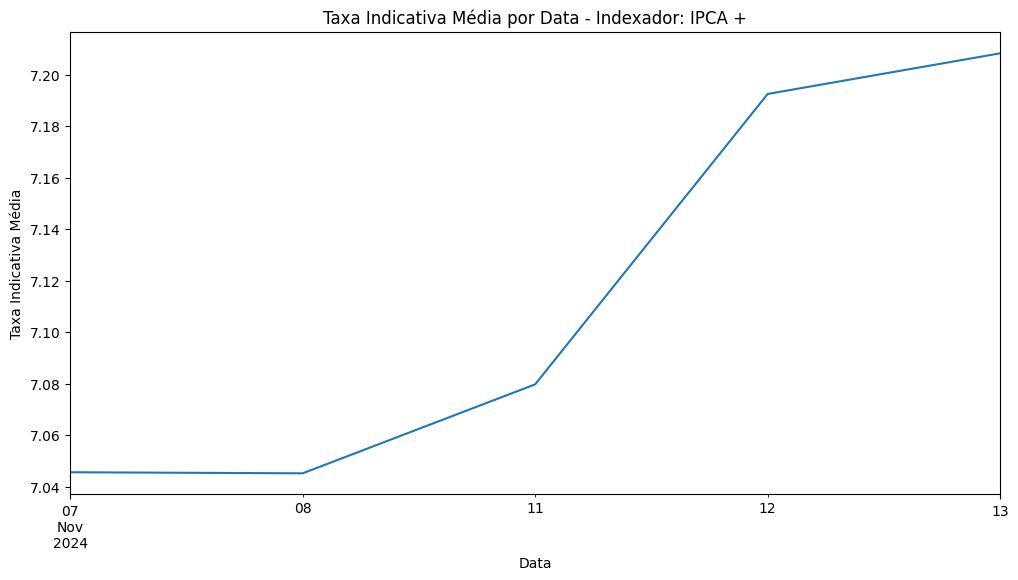

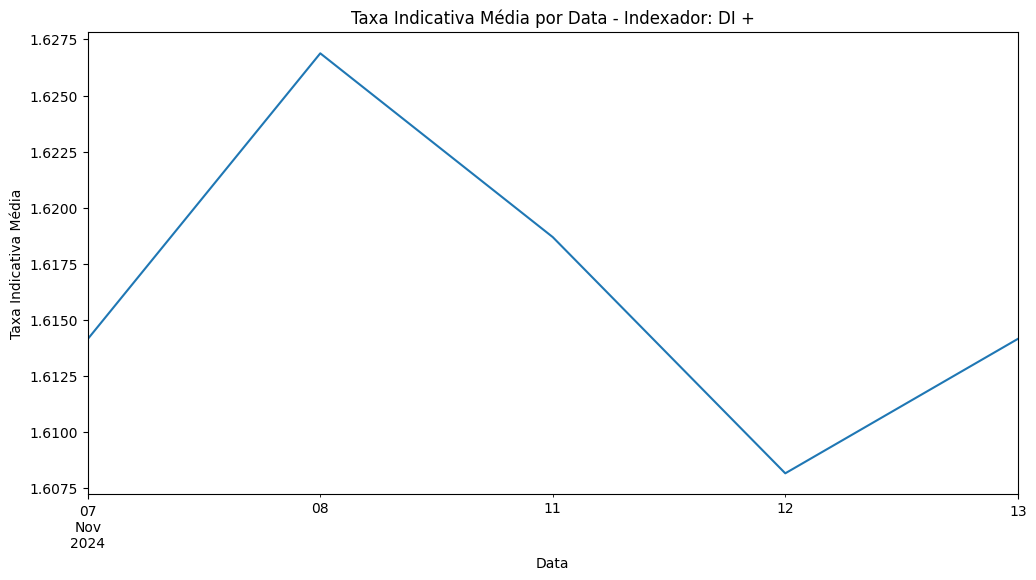

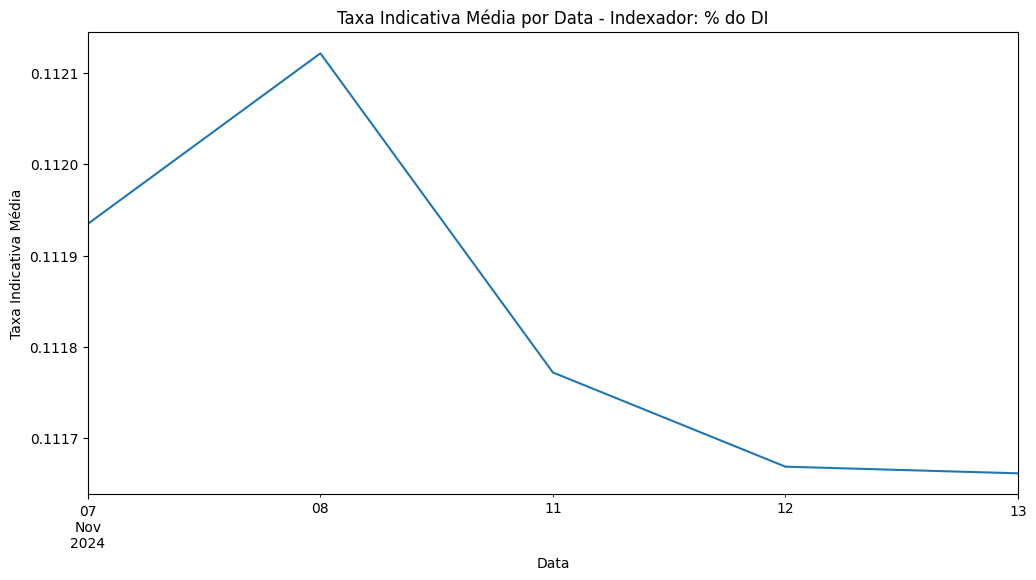

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("Daily Prices/bcp_final.csv")

data['Data'] = pd.to_datetime(data['Data'])

# 'Taxa Indicativa' -> numérico | 'coerce' -> valores inválidos
data['Taxa Indicativa'] = pd.to_numeric(data['Taxa Indicativa'], errors='coerce')

# Corrigir erros de ponto flutuante
data['Taxa Indicativa'] = data['Taxa Indicativa'].apply(lambda x: x / 1000 if x > 100 else x)

# Lista de indexadores únicos
indexadores = data['Indexador'].unique()

for indexador in indexadores:
    indexador_data = data[data['Indexador'] == indexador]
    mean_taxa_indicativa = indexador_data.groupby('Data')['Taxa Indicativa'].mean()
    
    # Plot
    plt.figure(figsize=(12, 6))
    mean_taxa_indicativa.plot()
    plt.xlabel("Data")
    plt.ylabel("Taxa Indicativa Média")
    plt.title(f"Taxa Indicativa Média por Data - Indexador: {indexador}")
    plt.show()